## Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import re
from collections import Counter
from wordcloud import WordCloud

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dropout, Dense
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
print(train_data.head())

   id keyword location                                               text  target
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...       1
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...       1
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1


In [10]:
print(test_data.head())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
print(train_data.describe(include='all'))


Train set statistics:
             id     keyword location                                               text  target
count   7613.00        7552     5080                                               7613 7613.00
unique      NaN         221     3341                                               7503     NaN
top         NaN  fatalities      USA  11-Year-Old Boy Charged With Manslaughter of T...     NaN
freq        NaN          45      104                                                 10     NaN
mean    5441.93         NaN      NaN                                                NaN    0.43
std     3137.12         NaN      NaN                                                NaN    0.50
min        1.00         NaN      NaN                                                NaN    0.00
25%     2734.00         NaN      NaN                                                NaN    0.00
50%     5408.00         NaN      NaN                                                NaN    0.00
75%     8146.00  

In [11]:
print(test_data.describe(include='all'))

             id  keyword  location                                               text
count   3263.00     3237      2158                                               3263
unique      NaN      221      1602                                               3243
top         NaN  deluged  New York  11-Year-Old Boy Charged With Manslaughter of T...
freq        NaN       23        38                                                  3
mean    5427.15      NaN       NaN                                                NaN
std     3146.43      NaN       NaN                                                NaN
min        0.00      NaN       NaN                                                NaN
25%     2683.00      NaN       NaN                                                NaN
50%     5500.00      NaN       NaN                                                NaN
75%     8176.00      NaN       NaN                                                NaN
max    10875.00      NaN       NaN                    

In [ ]:
print(train_data.isnull().sum())


Missing values in train set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


In [ ]:

print(test_data.isnull().sum())

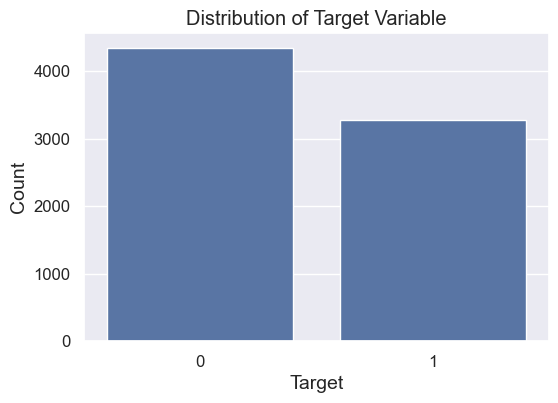

In [12]:

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [13]:
train_data["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [ ]:
train_data['char_count'] = train_data['text'].apply(len)
average_length = train_data['char_count'].mean()
min_length = train_data['char_count'].min()
max_length = train_data['char_count'].max()

print(f'Average Length: {average_length}')
print(f'Minimum Length: {min_length}')
print(f'Maximum Length: {max_length}')

Average Length: 101.03743596479706
Minimum Length: 7
Maximum Length: 157


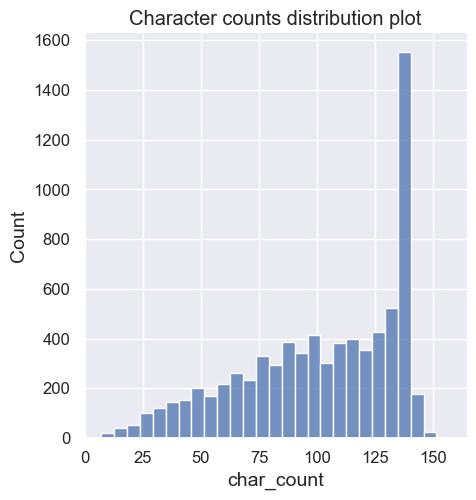

In [15]:
sns.displot(train_data['char_count'])
plt.title("Character counts distribution plot")
plt.show()

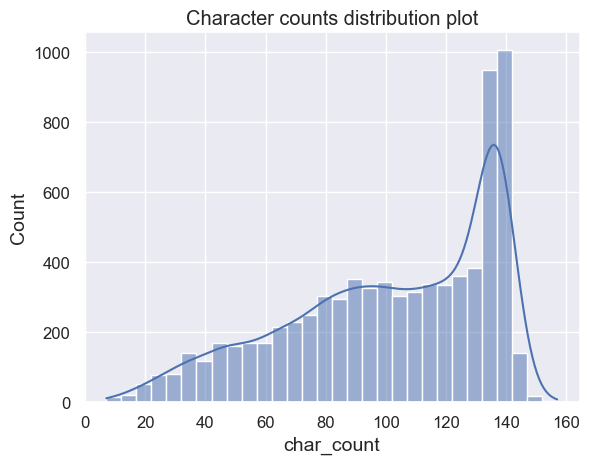

In [18]:
sns.histplot(train_data['char_count'], bins=30, kde=True)
plt.title("Character counts distribution plot")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


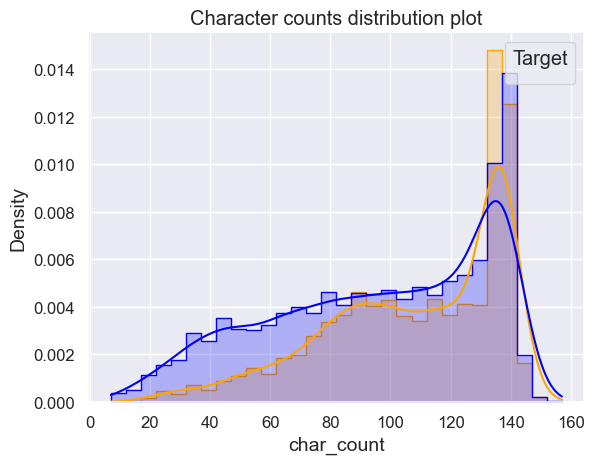

In [19]:
sns.histplot(
    data=train_data, 
    x='char_count', 
    hue='target', 
    bins=30, 
    kde=True, 
    palette={0: 'blue', 1: 'orange'}, 
    element='step', 
    stat='density'
)
plt.title("Character counts distribution plot")
plt.legend(title="Target")
plt.show()


In [20]:

all_text = ' '.join(train_data['text'].astype(str))
words = re.findall(r'\b\w+\b', all_text.lower())

In [21]:
word_counts = Counter(words)
total_words = sum(word_counts.values())

In [22]:
most_common_words = word_counts.most_common(10)
most_common_words

[('t', 5199),
 ('co', 4740),
 ('http', 4309),
 ('the', 3277),
 ('a', 2200),
 ('in', 1986),
 ('to', 1949),
 ('of', 1830),
 ('i', 1778),
 ('and', 1426)]

In [23]:
least_common_words = word_counts.most_common()[:-11:-1]
least_common_words

[('ymy4rskq3d', 1),
 ('stfmbbzfb5', 1),
 ('nf4iculoje', 1),
 ('rqkk15uhey', 1),
 ('symptoms', 1),
 ('developing', 1),
 ('forney', 1),
 ('5uecmcv2pk', 1),
 ('9km', 1),
 ('fa3fcnln86', 1)]

C:\Users\dusti\AppData\Local\Temp\ipykernel_2812\4262858226.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_most_common, x='Count', y='Word', palette='viridis')


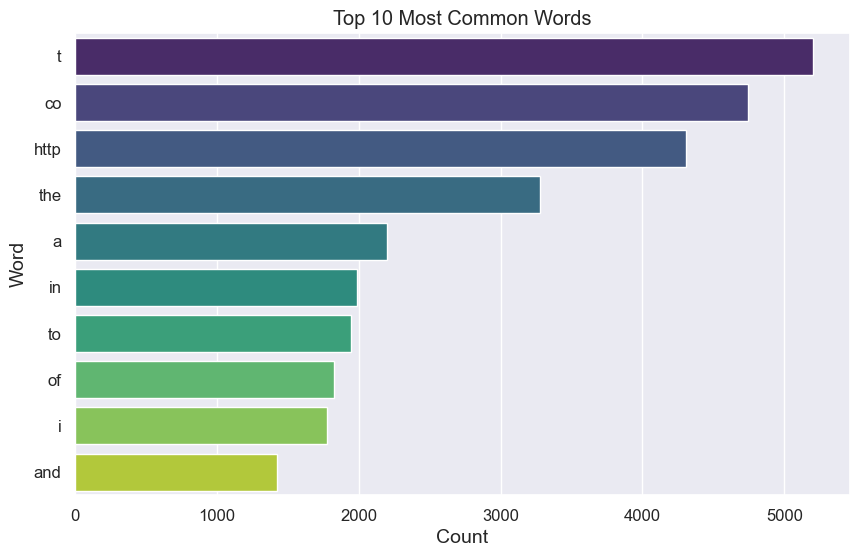

In [ ]:

df_most_common = pd.DataFrame(most_common_words, columns=['Word', 'Count'])


plt.figure(figsize=(10, 6))
sns.barplot(data=df_most_common, x='Count', y='Word', palette='viridis')


plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Most Common Words')

plt.show()

In [25]:
train_data['keyword'].fillna('missing_keyword', inplace=True)
train_data['location'].fillna('missing_location', inplace=True)
test_data['keyword'].fillna('missing_keyword', inplace=True)
test_data['location'].fillna('missing_location', inplace=True)

In [26]:
train_data.isnull().sum()

id            0
keyword       0
location      0
text          0
target        0
char_count    0
dtype: int64

In [27]:
test_data.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

In [28]:

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [32]:
train_data['combined_text'] = train_data['keyword'] + ' ' + train_data['location'] + ' ' + train_data['clean_text']
test_data['combined_text'] = test_data['keyword'] + ' ' + test_data['location'] + ' ' + test_data['clean_text']

## Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).

For this text classification task, I designed a sequential neural network that leverages the strengths of word embeddings and recurrent neural networks (RNNs) to capture the sequential and contextual information in text.

Overall Architecture Summary

- Input: Preprocessed text converted to padded sequences
- Embedding Layer: Learns dense word representations.
- Bidirectional LSTM Layer: Captures sequential dependencies from both directions.
- Dropout Layer: Reduces overfitting.
- Dense Layer: Outputs a binary classification decision.

This architecture was chosen because it effectively processes text by learning meaningful word representations and capturing the sequential nature of language, both of which are crucial for a successful text classification model.

In [ ]:
vocab_size = 10000
max_length = 100  
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['combined_text'])
train_sequences = tokenizer.texts_to_sequences(train_data['combined_text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')


model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,234,753 (4.71 MB)

 Trainable params: 1,234,753 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

Embedding Layer (embedding_1)

- Output Shape:
  - None indicates a flexible batch size.
  - 100 is the length of each input sequence (as specified by max_length).
  - The last 100 is the embedding dimension.



Bidirectional LSTM Layer (bidirectional_1)

- Output Shape:
  - Since the LSTM has 128 units in each direction (forward and backward), the outputs are concatenated, resulting in a 256-dimensional vector.




Dropout Layer (dropout_1)

- Output Shape:
  - The dropout layer doesn't change the shape; it only randomly sets a fraction of the input units to zero during training to help prevent overfitting.




Dense Output Layer (dense_1)

- Output Shape:
  - This single output neuron (with a sigmoid activation) is used for binary classification.




## Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6518 - loss: 0.6219 - val_accuracy: 0.7741 - val_loss: 0.4970
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.8394 - loss: 0.3835 - val_accuracy: 0.8056 - val_loss: 0.4639
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9032 - loss: 0.2499 - val_accuracy: 0.7708 - val_loss: 0.5139
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.9450 - loss: 0.1707 - val_accuracy: 0.7859 - val_loss: 0.5891
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.9618 - loss: 0.1143 - val_accuracy: 0.7689 - val_loss: 0.7172
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9776 - loss: 0.0716 - val_accuracy: 0.7761 - val_loss: 0.7334
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9726 - loss: 0.0651 - val_accuracy: 0.7715 - val_loss: 0.9312
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9817 - loss: 0.0528 - v

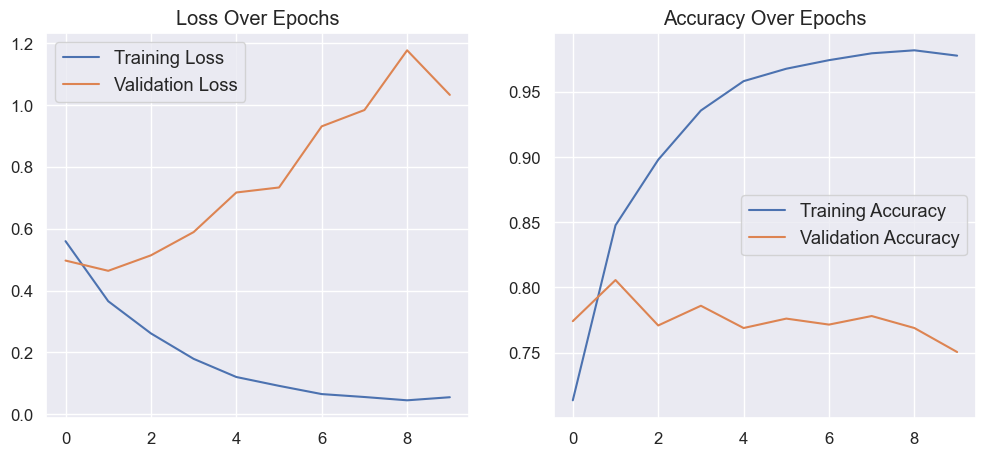

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


vocab_size = 10000  
max_length = 100  
embedding_dim = 100  #

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['combined_text'])

train_sequences = tokenizer.texts_to_sequences(train_data['combined_text'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(
    train_padded, train_data['target'], test_size=0.2, random_state=42
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()


### hyperparameter tuning

In [ ]:
vocab_size = 10000
embedding_dim = 100
max_length = 100

def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    
    rnn_type = hp.Choice('rnn_type', ['lstm', 'gru'])
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    
    if rnn_type == 'lstm':
        model.add(Bidirectional(LSTM(units)))
    else:
        model.add(Bidirectional(GRU(units)))
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='text_classification'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Optimal Hyperparameters:")
print(f"RNN Type: {best_hps.get('rnn_type')}")
print(f"Units: {best_hps.get('units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


Trial 30 Complete [00h 00m 30s]
val_accuracy: 0.7964543700218201

Best val_accuracy So Far: 0.8089297413825989
Total elapsed time: 00h 34m 24s
Optimal Hyperparameters:
RNN Type: gru
Units: 64
Dropout Rate: 0.6000000000000001
Learning Rate: 0.00021149313641035655


### Results and Analysis

#### 1. Baseline Model Results

Before hyperparameter tuning, our model achieved the following performance on the validation set:

| Metric              | Value    |
|---------------------|----------|
| Validation Loss     | 1.0329   |
| Validation Accuracy | 75.05%   |


#### 2. Hyperparameter Tuning Results

Using Keras Tuner with the Hyperband strategy, we optimized several key hyperparameters. Below is a summary table for the best configuration:

| Hyperparameter    | Optimal Value                  |
|-------------------|--------------------------------|
| RNN Type          | gru                            |
| Units             | 64                             |
| Dropout Rate      | 0.6                            |
| Learning Rate     | 0.000211                       |



#### 3. Analysis and Troubleshooting

- RNN Type (GRU vs. LSTM) - The GRU was found to be more effective on our dataset. This could be due to its fewer parameters, leading to better generalization given the available data.

- Number of Units - Using 64 units provided a balanced model complexity. Larger numbers of units might have led to overfitting, while too few might have underfit the data.

- Dropout Rate - A dropout rate of 0.6 helped mitigate overfitting by preventing the model from relying too heavily on any particular neuron.

- Learning Rate - A lower learning rate (approximately 0.000211) allowed the model to converge more smoothly without overshooting the optimal minima.


## Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

#### The hyperparameter tuning process significantly improved model performance by optimizing key architectural and training parameters. The resulting model, with a GRU layer (64 units), a 60% dropout rate, and a learning rate of 0.000211, achieved a validation accuracy of nearly 81%, compared to the 75% baseline.

- What Worked Well  
  - Regularization - The use of a dropout layer at a rate of 60% was effective in reducing overfitting.
  - Learning Rate Tuning - A smaller learning rate allowed for more stable convergence.
  - Model Architecture - Choosing between GRU and LSTM and settling on GRU showed that sometimes simpler recurrent structures can yield better results.

- What Did Not Help as Much
  - Excessive Model Complexity - Trials with a larger number of units (e.g., 128 or 256) did not perform as well, likely due to overfitting.
  - Extreme Dropout Rates - Dropout rates significantly lower or higher than 0.6 hindered performance, either by not providing enough regularization or by discarding too much information.

### Conclusion

The hyperparameter tuning process provided valuable insights into how different model configurations affect performance. While the tuned model achieved a significant improvement over the baseline, there remains room for further enhancements through advanced architectures, pre-trained embeddings, and more refined hyperparameter searches. These learnings will guide future iterations to further improve the model's generalization on unseen data.